In [1]:
from IPython.display import clear_output

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, RMSprop



In [2]:
import os

# Directory where the model will be saved
save_dir = '/model/'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Data Augmentation

In [20]:
# Load and preprocess data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # I used these values because I first implemented them like that and after running few model checked real ones. They are very comparable to real ones (mean, std).


transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees = 10),
    transforms.ColorJitter( brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 



train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, persistent_workers=True)


results_dict = {}

Files already downloaded and verified
Files already downloaded and verified


## Model 1 (main)

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels1x1, out_channels3x3_reduce, out_channels3x3, out_channels5x5_reduce, out_channels5x5, out_channels_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels1x1, kernel_size=1),
            nn.BatchNorm2d(out_channels1x1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels3x3_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels3x3_reduce, out_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels3x3),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels5x5_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels5x5_reduce, out_channels5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels5x5),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_pool, kernel_size=1),
            nn.BatchNorm2d(out_channels_pool),
            nn.ReLU()
        )

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)

        outputs = [branch1_out, branch2_out, branch3_out, branch4_out]
        return torch.cat(outputs, 1)

class Cifar10Classifier(nn.Module):
    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception2 = InceptionModule(64, 32, 32, 64, 8, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  # 3 dimensions mean [C, H, W] instead of [B, C, H, W] so we're dealing with a single image
            x = x.unsqueeze(dim=0)  # convert [C, H, W] to [1, C, H, W] where 1 will act as batch size
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.inception2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  # or x = x[0]

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Cifar10Classifier().to(device)
print(model)


Cifar10Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1

In [9]:
num_epochs = 50
lr = 1e-4

train_losses = []
val_losses = []

optimizer = RMSprop(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

model.to(device) 

print(f'Using device {device}')

Using device cuda


In [14]:
# %%time
optimizers = {
    'Adam': Adam,
    'RMSprop': RMSprop
} 

results = {}

for opt_name, opt_func in optimizers.items():
  optimizer = opt_func (model.parameters(), lr=lr)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='abs') 

  for epoch_no in range(num_epochs):

    model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

    epoch_weighted_loss = 0

    for batch_X, batch_y in train_loader:

      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)

      batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

      loss = criterion(batch_y_probs, batch_y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_weighted_loss += (len(batch_y)*loss.item())

    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)
    scheduler.step(loss)
    torch.save(model.state_dict(),'/model/model_'+ str(epoch_no) + ".pth")


    model.eval()  
    correctly_labelled = 0

    with torch.no_grad():

      val_epoch_weighted_loss = 0

      for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        val_batch_y_probs = model(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)
        val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  

    val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

  print(f'Training complete on device {device}.')

Epoch: 0, train_loss=1.0331127634260389, val_loss=0.9894673622131348. labelled 3252/5000 correctly (65.03999999999999% accuracy)
Epoch: 1, train_loss=0.9571336685816447, val_loss=0.9359390571594238. labelled 3346/5000 correctly (66.92% accuracy)
Epoch: 2, train_loss=0.9149775469568041, val_loss=0.8914625423431396. labelled 3419/5000 correctly (68.38% accuracy)
Epoch: 3, train_loss=0.862551851717631, val_loss=0.8463698183059692. labelled 3523/5000 correctly (70.46% accuracy)
Epoch: 4, train_loss=0.8243069606145222, val_loss=0.827278419303894. labelled 3533/5000 correctly (70.66% accuracy)
Epoch: 5, train_loss=0.7936535553402371, val_loss=0.7950366985321045. labelled 3580/5000 correctly (71.6% accuracy)
Epoch: 6, train_loss=0.7628498317294651, val_loss=0.7832808860778808. labelled 3629/5000 correctly (72.58% accuracy)
Epoch: 7, train_loss=0.7338611079533894, val_loss=0.7563415065765381. labelled 3648/5000 correctly (72.96000000000001% accuracy)
Epoch: 8, train_loss=0.7141460986455281, va

Accuracy: 0.8357
Precision: 0.8353
Recall: 0.8357
F1 Score: 0.8353
Confusion Matrix:
[[861   9  23  15  16   2   5   9  36  24]
 [  7 929   1   3   2   2   1   1   9  45]
 [ 50   1 755  30  71  33  37  18   5   0]
 [ 16   3  41 683  49 116  48  29   6   9]
 [  8   1  41  29 829  29  23  36   3   1]
 [  7   2  29 118  36 757  11  30   4   6]
 [  7   2  31  39  26  19 864   3   3   6]
 [  9   1  20  23  29  33   2 877   0   6]
 [ 40  16   8   8   5   3   0   3 896  21]
 [ 19  40   2   5   3   0   1   8  16 906]]


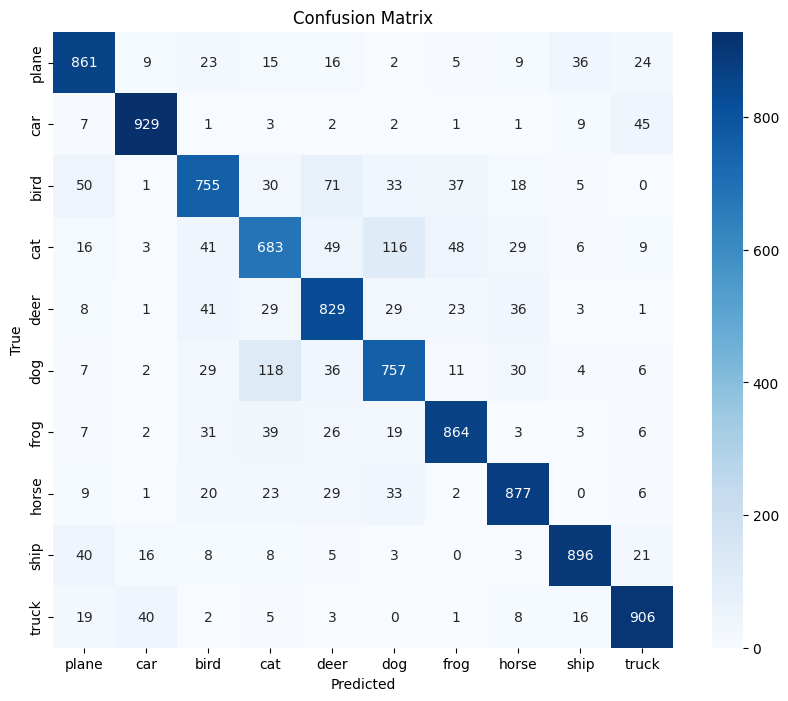

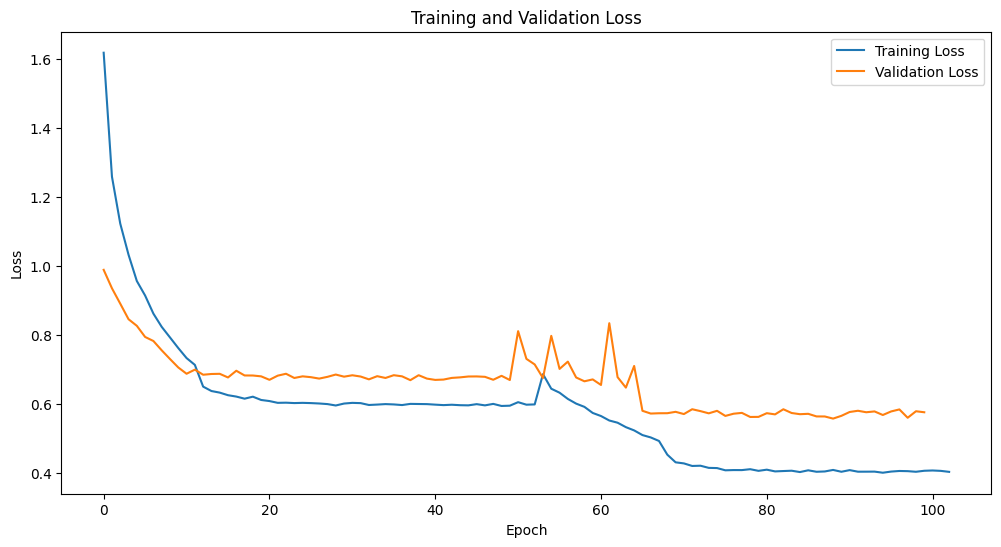

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []

model.eval()

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

results_dict["MainModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# Model 2 (helper)

In [21]:
class Cifar10Classifier2(nn.Module):
    def __init__(self):
        super(Cifar10Classifier2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  
            x = x.unsqueeze(dim=0) 
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0) 

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model2 = Cifar10Classifier2().to(device)
print(model2)


Cifar10Classifier2(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(

In [25]:
# %%time
optimizers = {
    'Adam': Adam,
    'RMSprop': RMSprop
}
train_losses = []
val_losses = []
results = {}

for opt_name, opt_func in optimizers.items():
  optimizer = opt_func (model2.parameters(), lr=lr)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
  for epoch_no in range(num_epochs):

    model2.train() 

    epoch_weighted_loss = 0

    for batch_X, batch_y in train_loader:

      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)

      batch_y_probs = model2(batch_X) 

      loss = criterion(batch_y_probs, batch_y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_weighted_loss += (len(batch_y)*loss.item())

    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)
    scheduler.step()
    torch.save(model2.state_dict(),'/model/model2_'+ str(epoch_no) + ".pth")


    model2.eval()  
    correctly_labelled = 0

    with torch.no_grad():

      val_epoch_weighted_loss = 0

      for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        val_batch_y_probs = model2(val_batch_X)
        loss = criterion(val_batch_y_probs, val_batch_y)
        val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

        val_batch_y_pred = val_batch_y_probs.argmax(dim=1) 

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item() 

    val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

  print(f'Training complete on device {device}.')

Epoch: 0, train_loss=0.7800468667030335, val_loss=0.7863038248062134. labelled 3598/5000 correctly (71.96000000000001% accuracy)
Epoch: 1, train_loss=0.7638574512057834, val_loss=0.7792142694473266. labelled 3639/5000 correctly (72.78% accuracy)
Epoch: 2, train_loss=0.7475197962019179, val_loss=0.7456289379119873. labelled 3665/5000 correctly (73.3% accuracy)
Epoch: 3, train_loss=0.730927652253045, val_loss=0.7547482774734497. labelled 3673/5000 correctly (73.46000000000001% accuracy)
Epoch: 4, train_loss=0.7119053905804952, val_loss=0.7422928504943848. labelled 3684/5000 correctly (73.68% accuracy)
Epoch: 5, train_loss=0.6702226359420352, val_loss=0.7137010725021362. labelled 3723/5000 correctly (74.46000000000001% accuracy)
Epoch: 6, train_loss=0.6537101124763489, val_loss=0.6995463388442993. labelled 3784/5000 correctly (75.68% accuracy)
Epoch: 7, train_loss=0.6459383380889893, val_loss=0.7002568675994874. labelled 3776/5000 correctly (75.52% accuracy)
Epoch: 8, train_loss=0.6329435

Accuracy: 0.8225
Precision: 0.8222
Recall: 0.8225
F1 Score: 0.8222
Confusion Matrix:
[[851   9  18  12  17   4   5   9  43  32]
 [ 13 911   1   3   2   0   2   0  16  52]
 [ 50   3 747  35  62  44  32  20   3   4]
 [ 19   4  55 656  48 130  38  27  12  11]
 [ 14   1  51  43 800  25  21  37   6   2]
 [  7   2  33 132  37 747  13  20   4   5]
 [  5   3  37  50  18  18 861   1   4   3]
 [  9   2  23  25  37  35   2 855   0  12]
 [ 47  19   7   6   1   1   1   2 897  19]
 [ 23  43   4   7   0   3   2   2  16 900]]


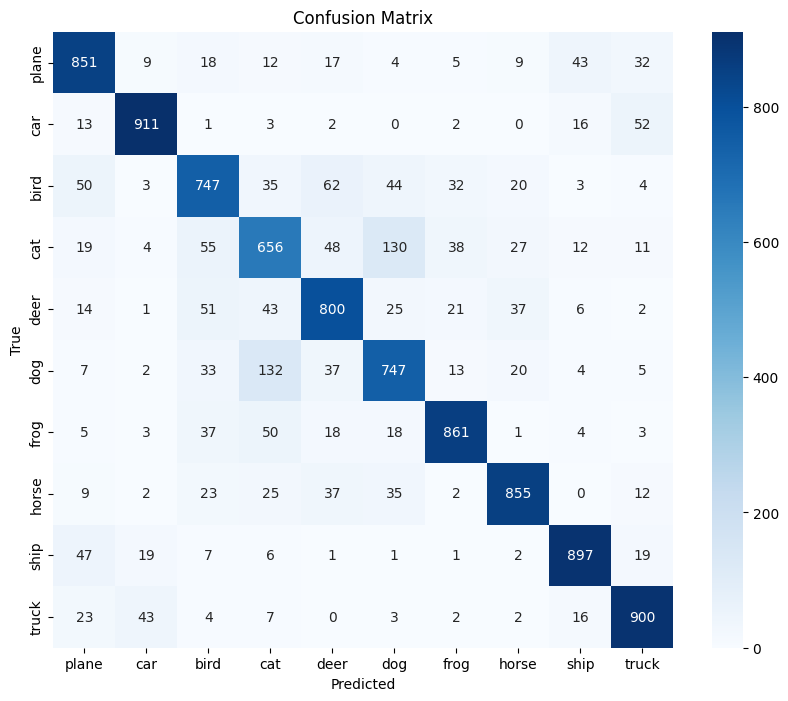

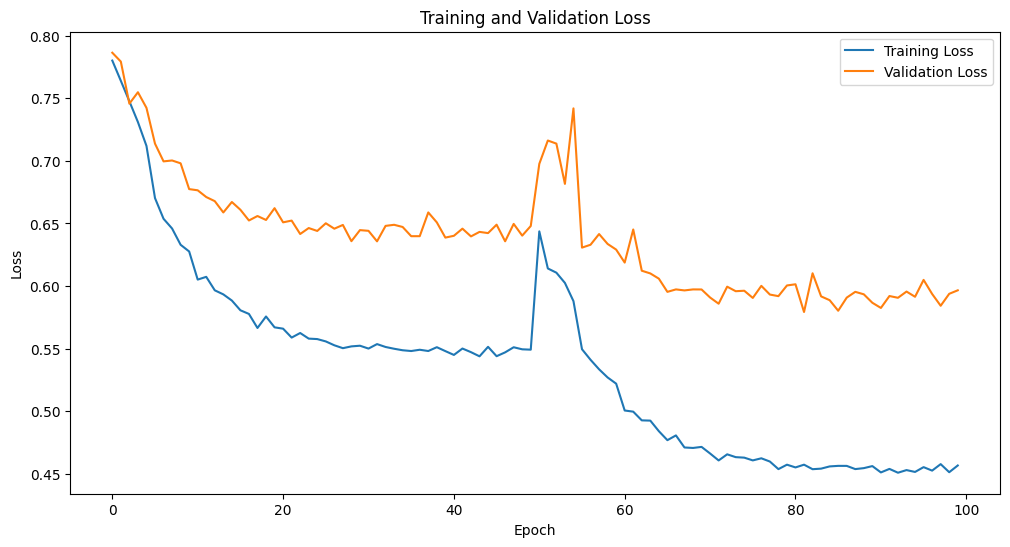

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []

model2.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model2(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
results_dict["SecondModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# Model 3 (helper)

In [22]:
class Cifar10Classifier3(nn.Module):
    def __init__(self):
        super(Cifar10Classifier3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  # 3 dimensions mean [C, H, W] instead of [B, C, H, W] so we're dealing with a single image
            x = x.unsqueeze(dim=0)  # convert [C, H, W] to [1, C, H, W] where 1 will act as batch size
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  # or x = x[0]

        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model3 = Cifar10Classifier3().to(device)
print(model3)


Cifar10Classifier3(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(

In [29]:
# %%time
optimizers = {
    'Adam': Adam,
    'RMSprop': RMSprop
}

results = {}
train_losses = []
val_losses = []

for opt_name, opt_func in optimizers.items():
  optimizer = opt_func (model3.parameters(), lr=lr)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
  for epoch_no in range(num_epochs):

    model3.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

    epoch_weighted_loss = 0

    for batch_X, batch_y in train_loader:

      batch_X = batch_X.to(device)
      batch_y = batch_y.to(device)

      batch_y_probs = model3(batch_X) 

      loss = criterion(batch_y_probs, batch_y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      epoch_weighted_loss += (len(batch_y)*loss.item())

    epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
    train_losses.append(epoch_loss)
    scheduler.step()
    torch.save(model3.state_dict(),'/model/model3_'+ str(epoch_no) + ".pth")

    # validation time

    model3.eval()  
    correctly_labelled = 0

    with torch.no_grad():

      val_epoch_weighted_loss = 0

      for val_batch_X, val_batch_y in val_loader:

        val_batch_X = val_batch_X.to(device)
        val_batch_y = val_batch_y.to(device)

        val_batch_y_probs = model3(val_batch_X)

        loss = criterion(val_batch_y_probs, val_batch_y)
        val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

        val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  

        correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item() 

    val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
    val_losses.append(val_epoch_loss)

    print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

  print(f'Training complete on device {device}.')



Epoch: 0, train_loss=0.7278913534906175, val_loss=0.7724751855850219. labelled 3645/5000 correctly (72.89999999999999% accuracy)
Epoch: 1, train_loss=0.7075086331897312, val_loss=0.7410421023368835. labelled 3687/5000 correctly (73.74000000000001% accuracy)
Epoch: 2, train_loss=0.6934049882041083, val_loss=0.7228263891220092. labelled 3752/5000 correctly (75.03999999999999% accuracy)
Epoch: 3, train_loss=0.6749895299699571, val_loss=0.7191935745239257. labelled 3775/5000 correctly (75.5% accuracy)
Epoch: 4, train_loss=0.660219521077474, val_loss=0.707082839679718. labelled 3774/5000 correctly (75.48% accuracy)
Epoch: 5, train_loss=0.6150522332297431, val_loss=0.6701983619689942. labelled 3845/5000 correctly (76.9% accuracy)
Epoch: 6, train_loss=0.6038080397605896, val_loss=0.650238802909851. labelled 3843/5000 correctly (76.86% accuracy)
Epoch: 7, train_loss=0.5955303690168593, val_loss=0.6674309530258179. labelled 3846/5000 correctly (76.92% accuracy)
Epoch: 8, train_loss=0.5838907879

Accuracy: 0.8418
Precision: 0.8413
Recall: 0.8418
F1 Score: 0.8414
Confusion Matrix:
[[884   7  27   7  15   1   3   4  35  17]
 [  4 938   3   4   1   2   2   0   5  41]
 [ 46   0 778  36  62  30  30   6   6   6]
 [ 18   5  55 683  46 106  44  27   9   7]
 [ 12   1  46  34 812  26  27  34   5   3]
 [ 13   2  32 125  32 753  11  27   3   2]
 [  5   4  31  41  13  21 876   0   5   4]
 [ 10   2  14  27  30  28   1 885   0   3]
 [ 45  12   6  10   2   2   2   0 907  14]
 [ 16  43   5   7   2   0   2   6  17 902]]


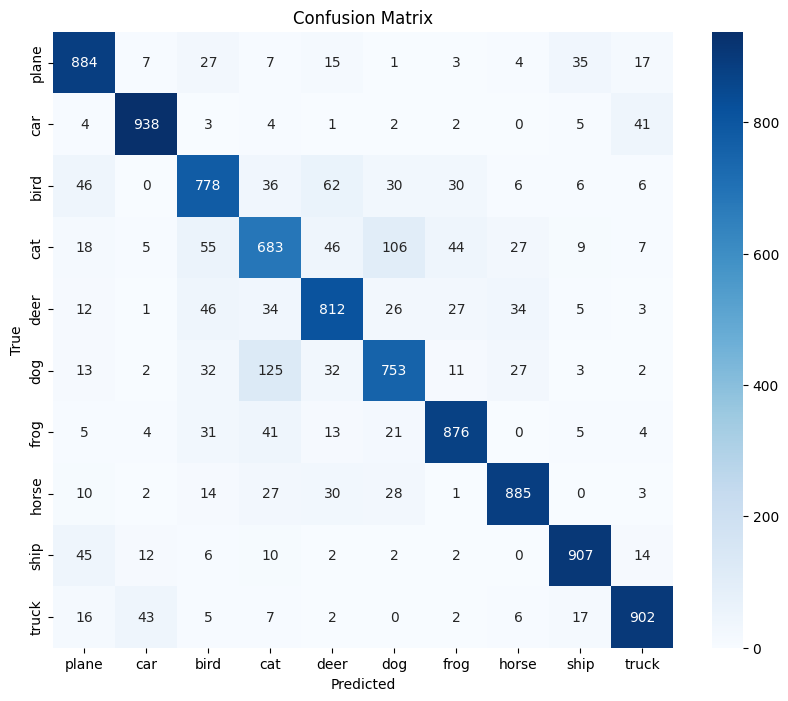

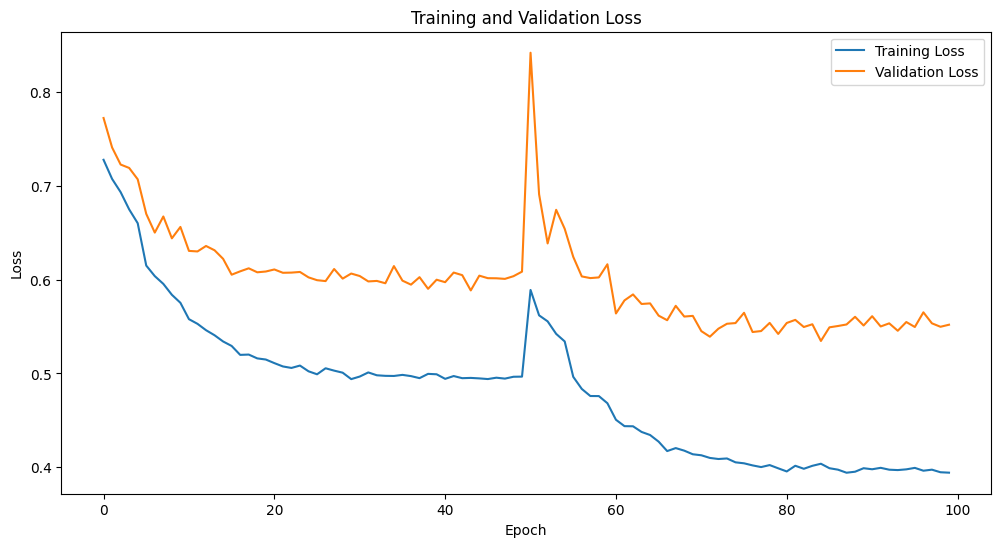

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

all_labels = []
all_preds = []
model3.eval()
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model3(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

results_dict["ThirdModel"] = (accuracy, precision, recall, f1, conf_matrix) 

# Ensemble model

Accuracy: 0.8560
Precision: 0.8558
Recall: 0.8560
F1 Score: 0.8558
Confusion Matrix:
[[884   7  27   7  15   1   3   4  35  17]
 [  4 938   3   4   1   2   2   0   5  41]
 [ 46   0 778  36  62  30  30   6   6   6]
 [ 18   5  55 683  46 106  44  27   9   7]
 [ 12   1  46  34 812  26  27  34   5   3]
 [ 13   2  32 125  32 753  11  27   3   2]
 [  5   4  31  41  13  21 876   0   5   4]
 [ 10   2  14  27  30  28   1 885   0   3]
 [ 45  12   6  10   2   2   2   0 907  14]
 [ 16  43   5   7   2   0   2   6  17 902]]


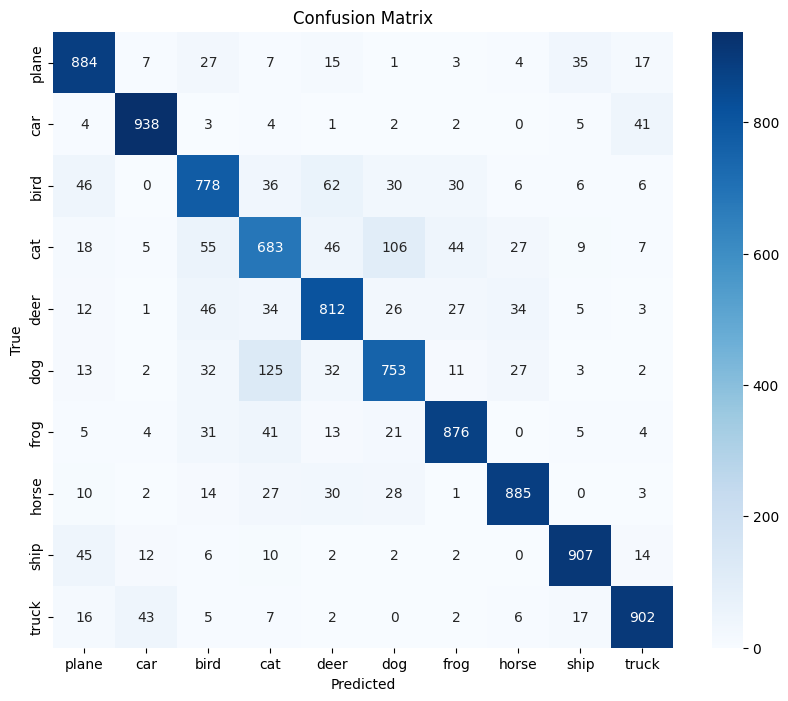

In [31]:
model.eval()
model2.eval()
model3.eval()

import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs1 = model(images)
        outputs2 = model2(images)
        outputs3 = model3(images)

        avg_outputs = (outputs1 + outputs2 + outputs3) / 3

        _, preds = torch.max(avg_outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["Ensemble"] = (accuracy, precision, recall, f1, conf_matrix) 



# AutoML (PyTorch Lightning)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning as L
criterion = nn.CrossEntropyLoss()  

class InceptionModule(nn.Module):
    def __init__(self, in_channels, out_channels1x1, out_channels3x3_reduce, out_channels3x3, out_channels5x5_reduce, out_channels5x5, out_channels_pool):
        super(InceptionModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels1x1, kernel_size=1),
            nn.BatchNorm2d(out_channels1x1),
            nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels3x3_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels3x3_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels3x3_reduce, out_channels3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels3x3),
            nn.ReLU()
        )

        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels5x5_reduce, kernel_size=1),
            nn.BatchNorm2d(out_channels5x5_reduce),
            nn.ReLU(),
            nn.Conv2d(out_channels5x5_reduce, out_channels5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(out_channels5x5),
            nn.ReLU()
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, out_channels_pool, kernel_size=1),
            nn.BatchNorm2d(out_channels_pool),
            nn.ReLU()
        )

        self.out_channels = out_channels1x1 + out_channels3x3 + out_channels5x5 + out_channels_pool

        # Ensure the residual connection has the same number of channels as the output of the Inception module
        if in_channels != self.out_channels:
            self.residual = nn.Conv2d(in_channels, self.out_channels, kernel_size=1)
        else:
            self.residual = nn.Identity()

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        branch3_out = self.branch3(x)
        branch4_out = self.branch4(x)

        inception_out = torch.cat([branch1_out, branch2_out, branch3_out, branch4_out], 1)
        residual_out = self.residual(x)

        return F.relu(inception_out + residual_out)

class Cifar10Classifier( L.LightningModule):
    def __init__(self):
        super(Cifar10Classifier, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception1 = InceptionModule(32, 16, 16, 32, 4, 8, 8)
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.inception2 = InceptionModule(64, 32, 32, 64, 8, 16, 16)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.fc2 = nn.Linear(512, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        single_input = False
        if x.ndim == 3:  # 3 dimensions mean [C, H, W] instead of [B, C, H, W] so we're dealing with a single image
            x = x.unsqueeze(dim=0)  # convert [C, H, W] to [1, C, H, W] where 1 will act as batch size
            single_input = True

        x = self.conv1(x)
        x = self.inception1(x)
        x = self.conv2(x)
        x = self.inception2(x)
        x = self.conv3(x)
        x = x.flatten(start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.log_softmax(x)

        if single_input:
            x = x.squeeze(dim=0)  # or x = x[0]

        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = criterion(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        preds = self.model(imgs).argmax(dim=-1)

        # Collect the labels and predictions
        true_labels = labels.tolist()
        predicted_labels = preds.tolist()

        return true_labels, predicted_labels

    def on_test_epoch_end(self, outputs):
        all_true_labels = []
        all_predicted_labels = []

        for true_labels, predicted_labels in outputs:
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)
        return all_true_labels, all_predicted_labels
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model4 = Cifar10Classifier().to(device)
print(model4)


Cifar10Classifier(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (inception1): InceptionModule(
    (branch1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (branch2): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (branch3): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1

In [ ]:
model4 = Cifar10Classifier().to(device)
trainer = L.Trainer(max_epochs=100)
trainer.fit(model4, train_loader, val_loader)

In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
torch.save(model4.state_dict(),'/model/model4_'+ str(99) + ".pth")
all_labels = []
all_preds = []

model4.eval()

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        # batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model4(batch_X)
        max_pred_values, preds = torch.max(outputs, 1)
        all_labels.extend(batch_y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

results_dict["AutoML"] = (accuracy, precision, recall, f1, conf_matrix) 


Accuracy: 0.8614
Precision: 0.8638
Recall: 0.8614
F1 Score: 0.8622
Confusion Matrix:
[[889   4  32  12   4   1   5   5  29  19]
 [  7 928   3   6   0   1   0   0   9  46]
 [ 28   1 839  41  35  28  14   9   2   3]
 [ 13   4  45 745  21 114  29  13  10   6]
 [  8   3  48  36 824  33  19  19   6   4]
 [  9   1  25 114  20 805   4  14   3   5]
 [  4   5  26  46  19  30 865   1   2   2]
 [  5   0  17  28  31  35   2 876   0   6]
 [ 33   5  11   7   2   2   4   0 920  16]
 [ 14  28   8  10   2   2   0   3  10 923]]


# Second ensemble

Accuracy: 0.8759
Precision: 0.8765
Recall: 0.8759
F1 Score: 0.8761
Confusion Matrix:
[[889   4  32  12   4   1   5   5  29  19]
 [  7 928   3   6   0   1   0   0   9  46]
 [ 28   1 839  41  35  28  14   9   2   3]
 [ 13   4  45 745  21 114  29  13  10   6]
 [  8   3  48  36 824  33  19  19   6   4]
 [  9   1  25 114  20 805   4  14   3   5]
 [  4   5  26  46  19  30 865   1   2   2]
 [  5   0  17  28  31  35   2 876   0   6]
 [ 33   5  11   7   2   2   4   0 920  16]
 [ 14  28   8  10   2   2   0   3  10 923]]


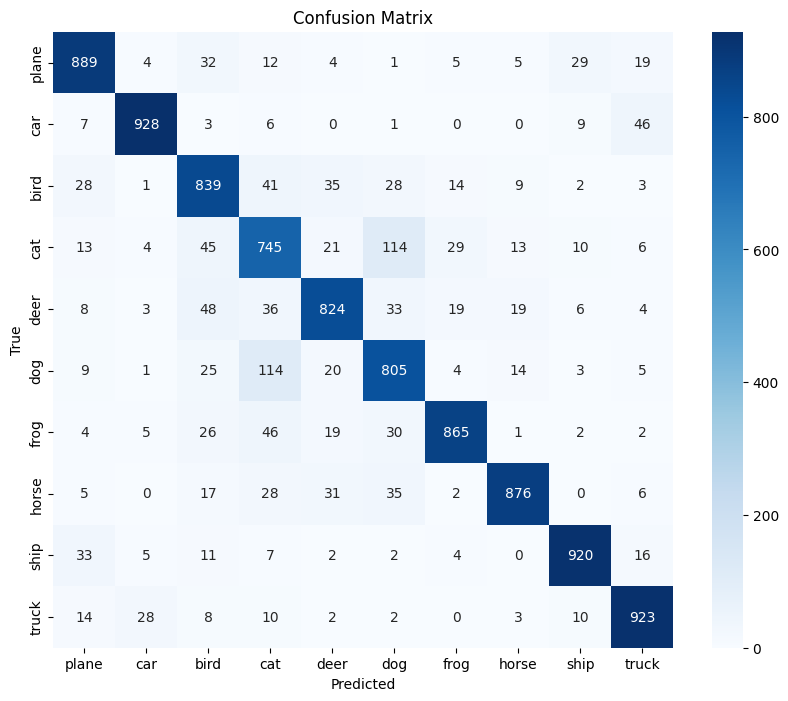

In [23]:
model = Cifar10Classifier().to(device)
model.load_state_dict(torch.load("/model/model_49.pth"))
model2 = Cifar10Classifier2().to(device)
model2.load_state_dict(torch.load("/model/model2_49.pth"))
model3 = Cifar10Classifier3().to(device)
model3.load_state_dict(torch.load("/model/model3_49.pth"))
# model4 = Cifar10Classifier().to(device)
# model4.load_state_dict(torch.load("/model/model4_99.pth"))
model.eval()
model2.eval()
model3.eval()
model4.eval()
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        imagesNotNotDevice, labelsNotDevice = images, labels
        images, labels = images.to(device), labels.to(device)

        outputs1 = model(images)
        outputs2 = model2(images)
        outputs3 = model3(images)
        outputs4 = model4(imagesNotNotDevice).to(device)
        avg_outputs = (outputs1 + outputs2 + outputs3 + outputs4) / 4

        _, preds = torch.max(avg_outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Confusion Matrix:\n{conf_matrix}')

import matplotlib.pyplot as plt
import seaborn as sns
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

results_dict["Second_ensemble"] = (accuracy, precision, recall, f1, conf_matrix) 
